In [1]:
import mne

In [2]:
import pandas as pd

In [3]:
import json

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [37]:
import matplotlib

In [38]:
%load_ext autoreload

%autoreload 2
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import datetime as dt

In [141]:
import eeg_events

# Проверка гипотезы

In [1645]:
baseline_raw = mne.io.read_raw_fif("./valid-data/processed/test-filtered-unprocessed.raw.fif", preload=True)

Opening raw data file ./valid-data/processed/test-filtered-unprocessed.raw.fif...
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.
Reading 0 ... 108903  =      0.000 ...   425.402 secs...


In [1646]:
events_df = pd.read_csv("./valid-data/processed/events-test-filtered.csv")

In [1647]:
%matplotlib

Using matplotlib backend: Qt5Agg


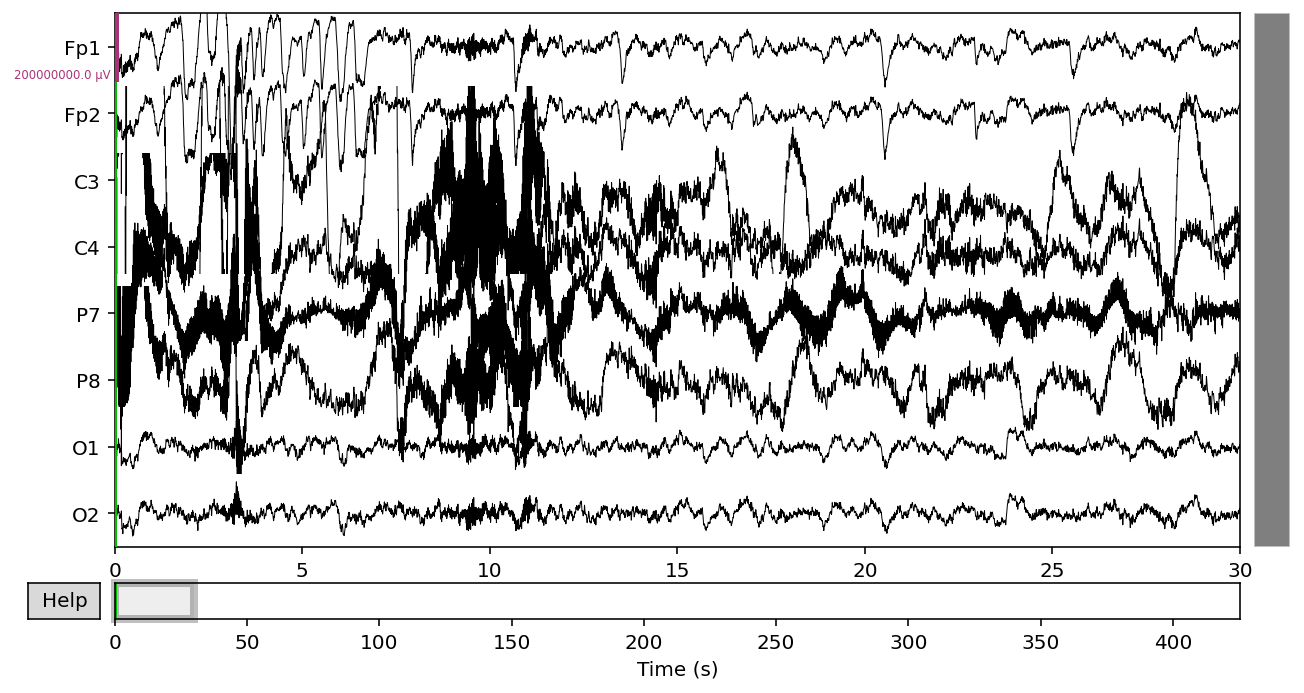

In [1648]:
_ = mne.viz.plot_raw(
    baseline_raw,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

### Добавить STI канал для фиксации событий

In [1649]:
sfreq = int(baseline_raw.info["sfreq"])

In [1650]:
eeg_data = baseline_raw.get_data()

In [1651]:
# eval(events_df["json"].iloc[0])

In [1652]:
# Событие - наличие или отсутствие пустой катушки в состоянии 000. Возможно - слишком близкие ивенты, сложно разделить
def check_hypothesis(response):
    response = response["response"]
    return "".join([str(s) for s in response['result']['state']['towerStages']]) == "000", \
        response["result"]['reels']['view'][0][0] == 5

In [1653]:
# # Событие - состояние 000
# def check_hypothesis(response):
#     response = response["response"]
#     return "".join([str(s) for s in response['result']['state']['towerStages']]) == "000"

In [1654]:
events_df["type_proxy"] = events_df["json"].apply(lambda x: eval(x)).apply(check_hypothesis)
# events_df["type_proxy"] = [(True, x > 315 // 2) for x in events_df.index]

In [1655]:
events_df["type"] = 'unknown'

In [1656]:
events_df.loc[events_df["type_proxy"] == (True, True), "type"] = 'empty reel'
events_df.loc[events_df["type_proxy"] == (True, False), "type"] = 'another action'

In [1657]:
events_df["type"].value_counts()

unknown           234
another action     41
empty reel         40
Name: type, dtype: int64

In [1658]:
stim_channel = np.zeros(eeg_data.shape[1])

true_timestamps = (events_df[events_df["type"] == 'empty reel']["timestamp"] * sfreq).astype(int)
stim_channel[true_timestamps[true_timestamps < stim_channel.shape[0]]] = 1

false_timestamps = (events_df[events_df["type"] == 'another action']["timestamp"] * sfreq).astype(int)
stim_channel[false_timestamps[false_timestamps < stim_channel.shape[0]]] = 2

In [1659]:
stim_info = mne.create_info(['STI'], baseline_raw.info['sfreq'], ['stim'])

In [1660]:
stim_raw = mne.io.RawArray(stim_channel.reshape(1, -1), stim_info)

Creating RawArray with float64 data, n_channels=1, n_times=108904
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.


In [1661]:
baseline_raw.add_channels([stim_raw], force_update_info=True)

<Raw | test-filtered-unprocessed.raw.fif, 9 x 108904 (425.4 s), ~7.5 MB, data loaded>

In [1662]:
events = mne.find_events(baseline_raw, stim_channel="STI")

81 events found
Event IDs: [1 2]


In [1663]:
raw_part = baseline_raw.copy().pick(["Fp1", "Fp2", "O1", "O2"])

In [1664]:
%matplotlib

Using matplotlib backend: Qt5Agg


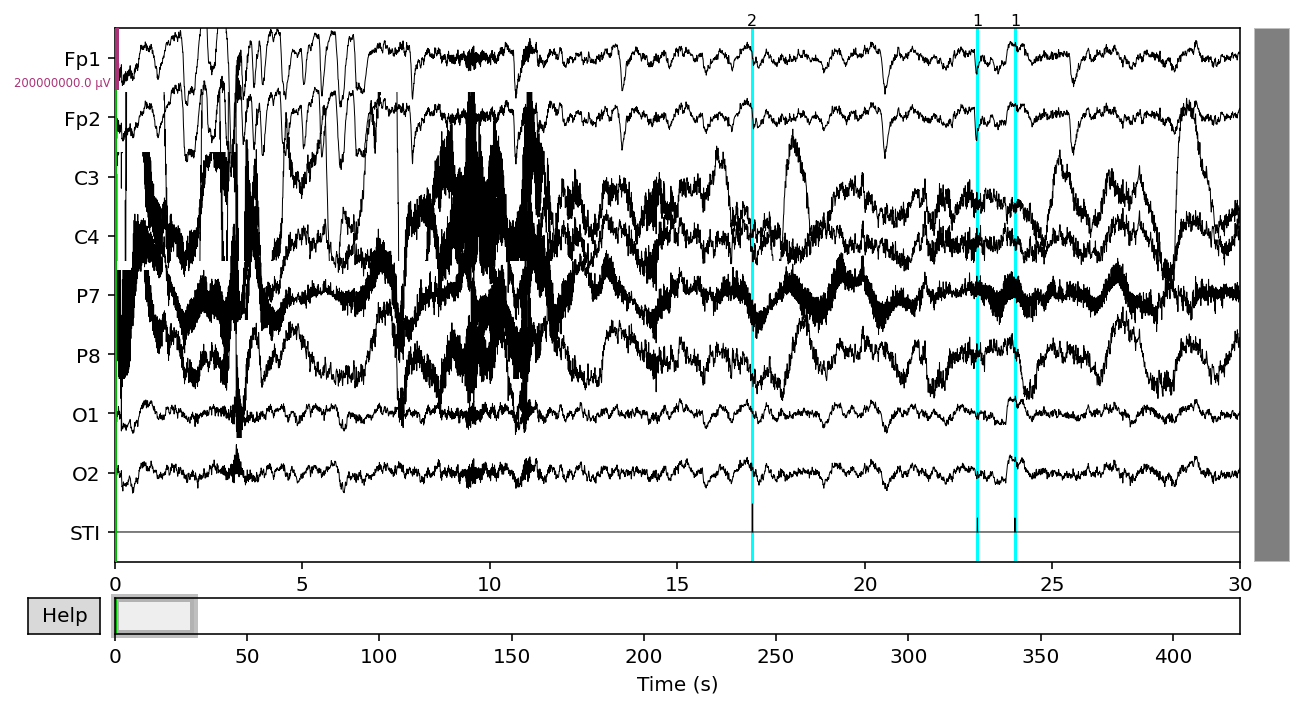

In [1665]:
_ = mne.viz.plot_raw(
    baseline_raw,
    events,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

In [1666]:
epochs = mne.Epochs(
    baseline_raw,
    events,
    tmin=0,
    tmax=10,
    preload=True,
    baseline=None#(None, 0)
)

Not setting metadata
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Loading data for 81 events and 2561 original time points ...
1 bad epochs dropped


In [1667]:
epochs_part = epochs.copy().pick(["O1", "O2"])

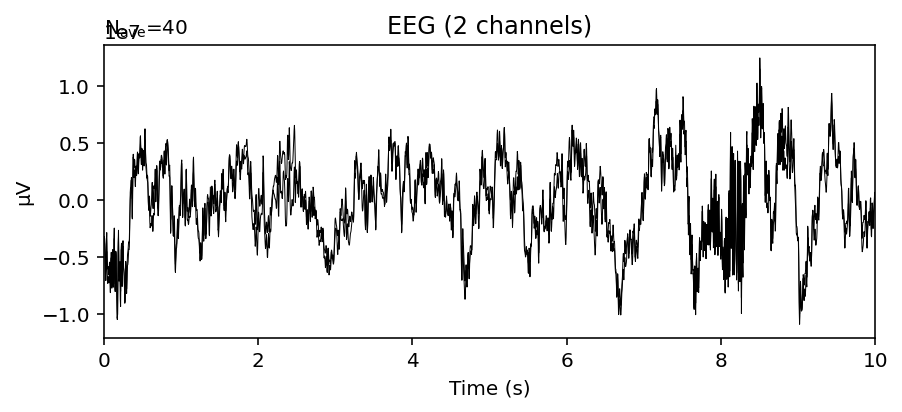

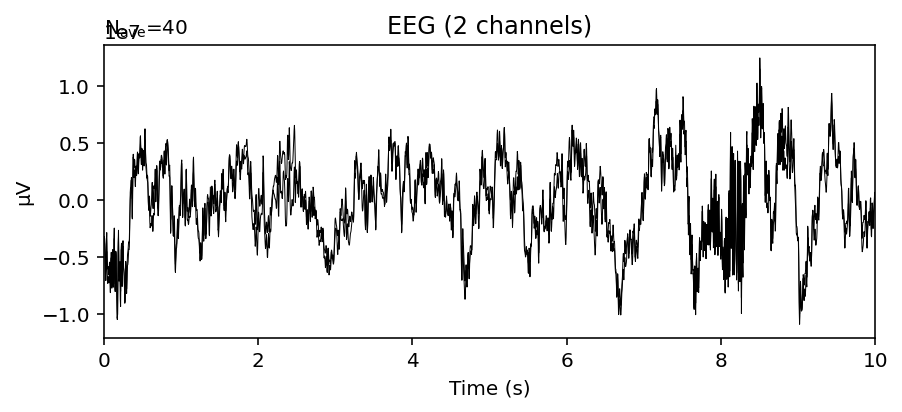

In [1668]:
# Средняя попытка для пустой катушки
epochs_part['1'].average().plot()

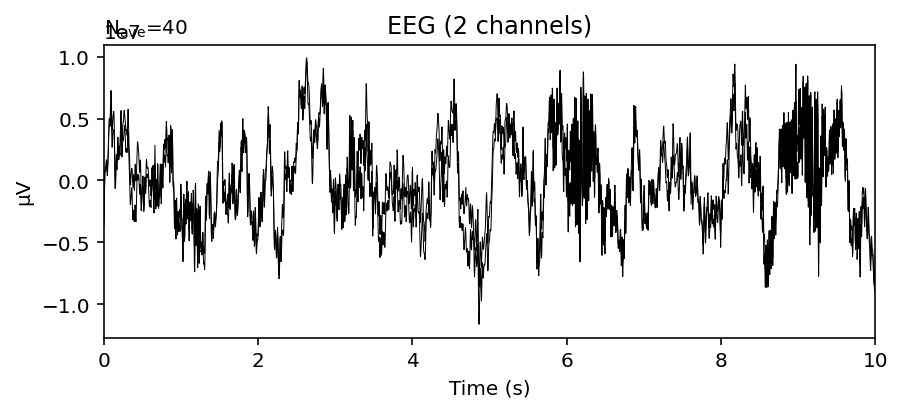

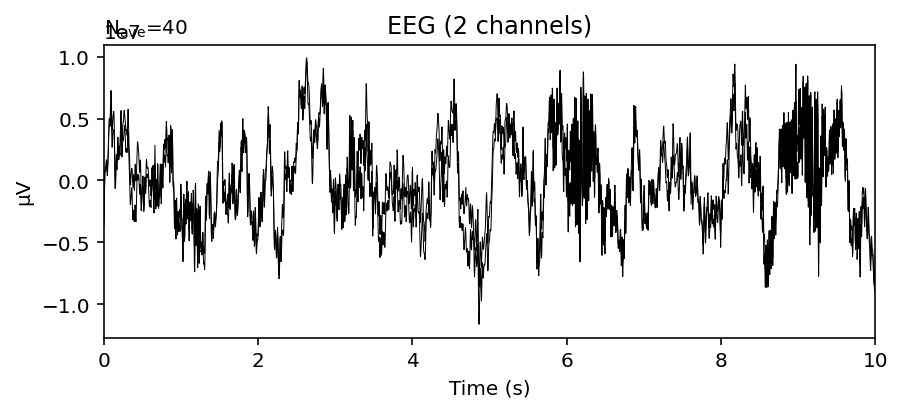

In [1669]:
# Средняя попытка для других символов
epochs_part['2'].average().plot()

# Проверка гипотезы

TODO уточнить ожидаемый размер эффекта

Ожидаемый результат - для пустой катушки амплитуда альфа-ритма должна быть больше, чем для других символов

In [1670]:
empty_reel_data = epochs_part['1'].get_data()

In [1671]:
other_action_data = epochs_part['2'].get_data()

In [1672]:
def filter_by_mean(data):
    mean_abs_values = np.abs(data.max(axis=2)).reshape(-1)
    return data[np.argsort(-mean_abs_values)[0:]]

In [1673]:
from scipy import stats

In [1674]:
def filter_by_std(data):
    mean_abs_values = (data.std(axis=2)).reshape(-1)
    return data[np.argsort(-mean_abs_values)[5:]]

In [1675]:
def filter_by_kurtosis(data):
    mean_abs_values = (stats.kurtosis(data, axis=2)).reshape(-1)
    return data[np.argsort(-mean_abs_values)[10:]]

In [1676]:
# empty_reel_data = filter_by_kurtosis(empty_reel_data)
# other_action_data = filter_by_kurtosis(other_action_data)

In [1677]:
import seaborn as sns

In [1678]:
import plotly.express as px

In [1679]:
# plt.figure(figsize=(20, 10))
# plt.plot(other_action_data.reshape(other_action_data.shape[0], -1).T, color='blue')
# plt.plot(empty_reel_data.reshape(empty_reel_data.shape[0], -1).T, color='red')
# plt.show()

In [1680]:
empty_reel_data.shape

(40, 2, 2561)

In [1681]:
empty_reel_frequencies = np.abs(np.fft.fft(empty_reel_data, 256, axis=-1))[:, :, :30]

In [1682]:
import seaborn as sns

In [1683]:
empty_reel_frequencies.mean(axis=0)

array([[1229.00565559, 2142.16583698, 1391.86574075,  929.44853918,
         702.48687505,  528.79084409,  490.70004262,  421.05406415,
         363.18294821,  323.30480884,  298.28340766,  236.29034142,
         246.21339208,  225.20296021,  204.21546772,  206.67280529,
         174.84470947,  173.10255   ,  180.62985385,  168.59508326,
         176.54609943,  134.53473353,  132.85194546,  133.01623536,
         128.05866258,  145.36797857,  135.33934239,  115.87309736,
         104.33196049,  115.36924047],
       [1202.44012007, 2160.32439319, 1361.49087211,  981.64479842,
         753.47101337,  550.05084255,  491.72649693,  447.47953703,
         378.15987683,  307.45492316,  321.87731827,  243.58803957,
         274.81581562,  240.81144066,  217.29776523,  231.96457023,
         171.98152646,  196.5279013 ,  185.62534113,  189.5134014 ,
         176.26777566,  154.46334528,  147.38817393,  159.96140639,
         138.11666922,  148.51693072,  146.48383002,  115.32624961,
         

In [1684]:
other_frequencies = np.abs(np.fft.fft(other_action_data, 256, axis=-1))[:, :, :30]

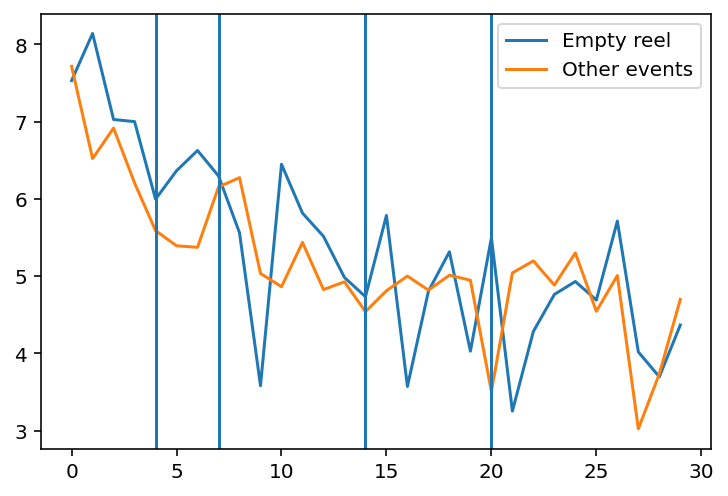

In [1756]:
plt.plot(np.log(empty_reel_frequencies[np.random.choice(np.arange(empty_reel_frequencies.shape[0])), 0, :]), label="Empty reel")
plt.plot(np.log(other_frequencies[np.random.choice(np.arange(other_frequencies.shape[0])), 0, :]), label="Other events")
plt.axvline(4)
plt.axvline(7)
plt.axvline(14)
plt.axvline(20)
plt.legend()

In [1686]:
other_frequencies.mean(axis=0)

array([[1089.95790327, 1751.16882222, 1456.57029729,  844.56733382,
         629.53636538,  554.70125469,  473.16413492,  433.45335022,
         327.57001364,  343.18876634,  310.10986513,  257.50561198,
         230.97870578,  231.37280212,  214.04445214,  172.62037857,
         189.08158691,  165.46698465,  148.85417353,  136.51712345,
         179.28854244,  138.37340304,  132.56580813,  144.32645284,
         140.30200013,  121.59202742,  151.70737443,  129.15005663,
         116.18719327,  134.41433713],
       [1110.67984809, 1694.23781559, 1421.91524665,  905.81749511,
         592.45804137,  590.16094691,  465.83762619,  433.3286173 ,
         318.49963735,  368.38810204,  308.6171777 ,  229.10313139,
         255.12613845,  247.56128631,  206.84160449,  181.28214428,
         192.43449712,  168.2442957 ,  165.86354466,  148.81424973,
         163.8779587 ,  141.90763661,  135.84513569,  144.85006071,
         146.98707298,  125.96986071,  165.06366715,  123.72215123,
         

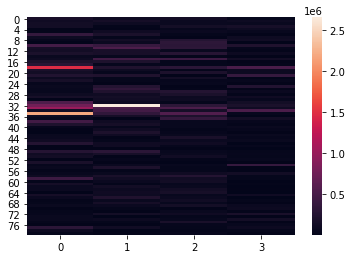

In [1453]:
sns.heatmap(empty_reel_frequencies.mean(axis=1))

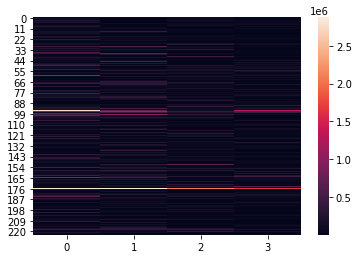

In [1454]:
sns.heatmap(other_frequencies.mean(axis=1))

In [1455]:
sample_empty = empty_reel_frequencies.mean(axis=-1).mean(axis=-1)

In [1456]:
sample_other = other_frequencies.mean(axis=-1).mean(axis=-1)

In [1457]:
# sample_empty = empty_reel_data.mean(axis=2).mean(axis=1) #.std(axis=2).mean(axis=1)

In [1458]:
# sample_other = other_action_data.mean(axis=2).mean(axis=1)

In [1459]:
%matplotlib inline

(array([5.24880060e-06, 8.52930098e-06, 5.57685064e-06, 2.95245034e-06,
        9.84150113e-07, 0.00000000e+00, 6.56100075e-07, 3.28050038e-07,
        3.28050038e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.28050038e-07, 0.00000000e+00, 3.28050038e-07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([ 20738.03695946,  60326.54937195,  99915.06178444, 139503.57419693,
        179092.08660942, 218680.5990219 , 258269.11143439, 297857.62384688,
        337446.13625937, 377034.64867186, 416623.16108435, 456211.67349684,
        495800.18590933, 535388.69832182, 574977.21073431, 614565.7231468 ,
        654154.23555929, 693742.74797177, 733331.26038426, 772919.77279675]),
 <a list of 19 Patch objects>)

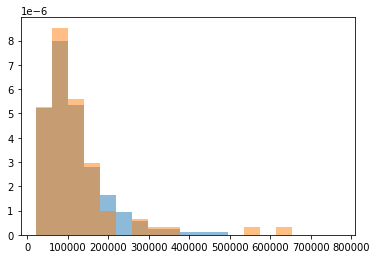

In [1460]:
bins=np.linspace(np.quantile(sample_other, 0.01), np.quantile(sample_other, 0.99), 20)
plt.hist(sample_other, bins=bins, alpha=0.5, density=True)
plt.hist(sample_empty, bins=bins, alpha=0.5, density=True)

In [1439]:
from scipy.stats import mannwhitneyu

In [1440]:
from scipy.stats import ttest_ind

In [1441]:
sample_other.mean()

305.49703049145563

In [1442]:
sample_empty.mean()

308.4452480946598

In [1443]:
ttest_ind(sample_other, sample_empty)

Ttest_indResult(statistic=-0.16476720537648043, pvalue=0.8692374470201202)

In [1444]:
mannwhitneyu(sample_other, sample_empty)

MannwhitneyuResult(statistic=8811.0, pvalue=0.41292068823228195)